    Consumo_T  Consumo_Aula Medios_Pred  Consumo_Cubiculos_Pred  \
0    1.742880                  0.014041                0.000000   
1    4.487123                  0.131724                0.000000   
2    2.652836                  0.012700                0.052326   
3    0.209674                  0.001100                0.000000   
4    4.365746                  0.015796                2.215274   
..        ...                       ...                     ...   
95   4.199466                  0.013475                2.424874   
96   4.154552                  0.013980                2.589121   
97   0.576384                  0.012030                0.000000   
98   0.984649                  0.012067                0.000000   
99   2.300501                  0.014055                0.000000   

    Consumo_Direccion 1_Pred  Consumo_Direccion 2_Pred  Consumo_Rack_Pred  \
0                   0.022940                  0.228021           0.225931   
1                   0.021418             

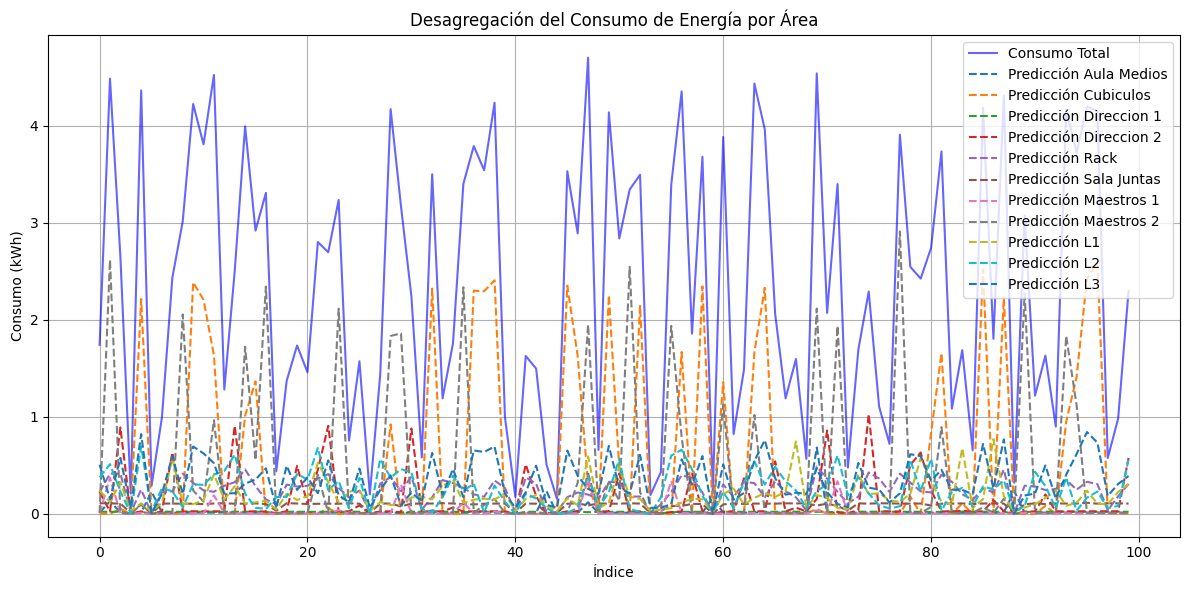

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import joblib
import matplotlib.pyplot as plt

# Cargar datos reales desde un archivo CSV
df = pd.read_csv('universidad.csv')

# Preparar los datos para el modelo
X = df[['Consumo_T']]  # Consumo total como entrada
areas = ['Aula Medios', 'Cubiculos', 'Direccion 1', 'Direccion 2', 'Rack', 
         'Sala Juntas', 'Maestros 1', 'Maestros 2', 'L1', 'L2', 'L3']

# Crear y entrenar un modelo para cada área
modelos = {}
for area in areas:
    y = df[area]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Crear y entrenar el modelo para esta área
    modelo = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo.fit(X_train, y_train)
    
    # Guardar el modelo entrenado
    joblib.dump(modelo, f'modelo_{area}.pkl')
    
    # Almacenar el modelo en el diccionario
    modelos[area] = modelo

# 2. Desagregar consumo de nuevos datos
def desagregar_consumo(nuevos_datos):
    # Crear un diccionario para almacenar las predicciones ajustadas
    predicciones_ajustadas = {}

    for area in areas:
        # Cargar el modelo entrenado para el área
        modelo = joblib.load(f'modelo_{area}.pkl')

        # Realizar predicciones utilizando el consumo total
        predicciones = modelo.predict(nuevos_datos[['Consumo_T']])
        predicciones_ajustadas[area] = predicciones
    
    # Convertir las predicciones ajustadas en un DataFrame
    predicciones_df = pd.DataFrame(predicciones_ajustadas)

    # Ajustar las predicciones para que sumen a 'Consumo_Total'
    predictions_total = predicciones_df.sum(axis=1)
    scaling_factor = np.where(predictions_total > nuevos_datos['Consumo_T'], 
                              nuevos_datos['Consumo_T'] / predictions_total, 1.0)
    
    # Ajustar cada predicción según el factor de escalado
    for area in areas:
        predicciones_df[area] = predicciones_df[area] * scaling_factor

    # Agregar las predicciones ajustadas al DataFrame original
    for area in areas:
        nuevos_datos[f'Consumo_{area}_Pred'] = predicciones_df[area]

    return nuevos_datos

# Crear un nuevo DataFrame con datos generales (puedes ajustar los datos reales)
df_nuevo = pd.DataFrame({
    'Consumo_T': np.random.uniform(low=0.1, high=5, size=100)  # Sustituir por datos reales
})

# Desagregar los nuevos datos
resultados = desagregar_consumo(df_nuevo)

# Mostrar resultados
print(resultados[['Consumo_T'] + [f'Consumo_{area}_Pred' for area in areas]])

# Guardar los resultados en un nuevo archivo CSV
resultados.to_csv('resultados_desagregados_universidad.csv', index=False)

# 3. Graficar los resultados de la desagregación
plt.figure(figsize=(12, 6))
plt.plot(resultados['Consumo_T'], label='Consumo Total', color='blue', alpha=0.6)

for area in areas:
    plt.plot(resultados[f'Consumo_{area}_Pred'], label=f'Predicción {area}', linestyle='--')

plt.title('Desagregación del Consumo de Energía por Área')
plt.xlabel('Índice')
plt.ylabel('Consumo (kWh)')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()


Index(['Consumo_T', 'Aula Medios', 'Cubiculos', 'Direccion 1', 'Direccion 2',
       'Rack', 'Sala Juntas', 'Maestros 1', 'Maestros 2', 'L1', 'L2', 'L3'],
      dtype='object')
      Consumo_T  Aula_Medios_Pred  Cubiculos_Pred  Direccion1_Pred  \
0        3.9591          0.013842        2.231992         0.022490   
1        3.9457          0.011209        0.023813         0.022312   
2        3.9534          0.011949        0.048458         0.022366   
3        1.7530          0.014262        0.003102         0.022202   
4        1.7523          0.014471        0.003102         0.022171   
...         ...               ...             ...              ...   
9364     3.7201          0.012810        1.548388         0.021625   
9365     3.9615          0.013387        2.225377         0.022455   
9366     3.8149          0.012903        1.713668         0.022242   
9367     3.7123          0.012840        2.030798         0.021814   
9368     3.7127          0.012840        2.030798    

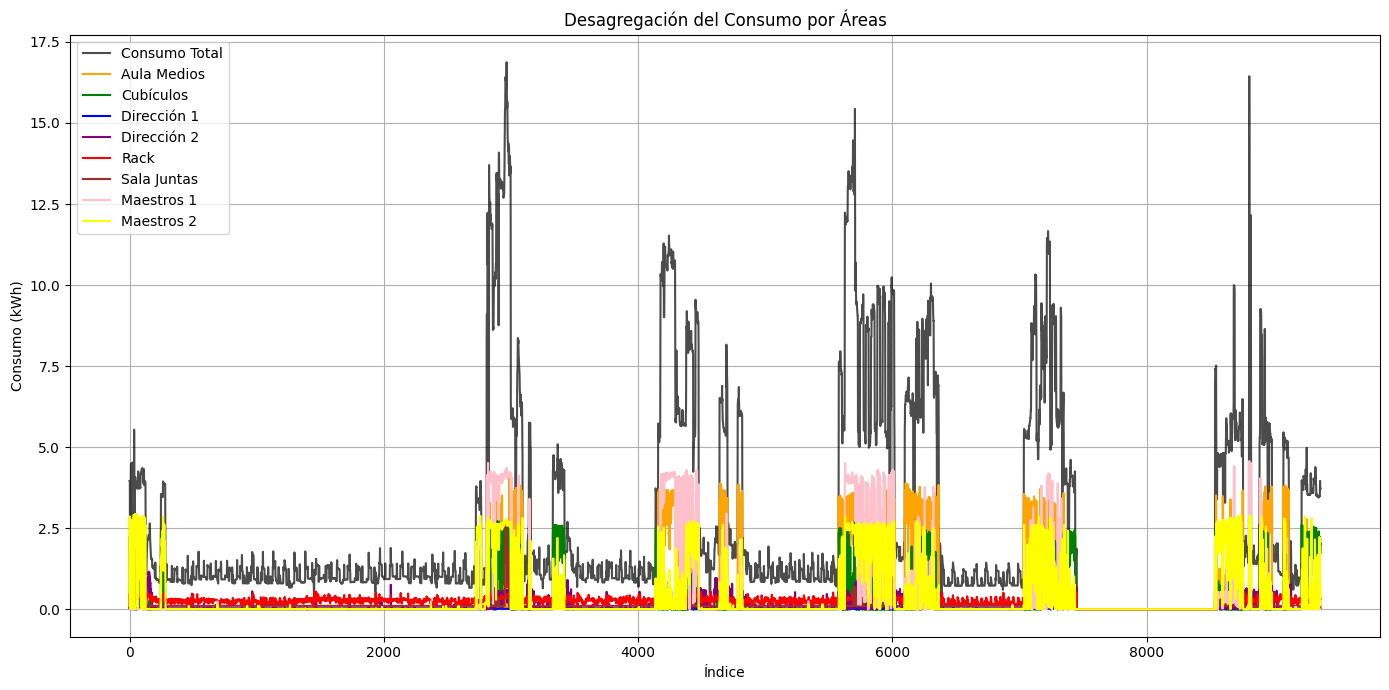

In [6]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt  # Importar matplotlib para graficar

# 1. Cargar los nuevos datos desde un archivo CSV
nuevos_datos = pd.read_csv('universidad.csv')  # Asegúrate de que la ruta sea correcta

# 2. Verificar las columnas de nuevos_datos
print(nuevos_datos.columns)  # Esto te ayudará a entender qué columnas están disponibles

# Desagregar consumo usando la función ajustada
def desagregar_consumo(nuevos_datos):
    # Cargar modelos entrenados para cada área
    model_aula_medios = joblib.load('modelo_Aula Medios.pkl')
    model_cubiculos = joblib.load('modelo_Cubiculos.pkl')
    model_direccion1 = joblib.load('modelo_Direccion 1.pkl')
    model_direccion2 = joblib.load('modelo_Direccion 2.pkl')
    model_rack = joblib.load('modelo_Rack.pkl')
    model_sala_juntas = joblib.load('modelo_Sala Juntas.pkl')
    model_maestros1 = joblib.load('modelo_Maestros 1.pkl')
    model_maestros2 = joblib.load('modelo_Maestros 2.pkl')
    
    # Realizar predicciones utilizando el consumo total
    pred_aula_medios = model_aula_medios.predict(nuevos_datos[['Consumo_T']])
    pred_cubiculos = model_cubiculos.predict(nuevos_datos[['Consumo_T']])
    pred_direccion1 = model_direccion1.predict(nuevos_datos[['Consumo_T']])
    pred_direccion2 = model_direccion2.predict(nuevos_datos[['Consumo_T']])
    pred_rack = model_rack.predict(nuevos_datos[['Consumo_T']])
    pred_sala_juntas = model_sala_juntas.predict(nuevos_datos[['Consumo_T']])
    pred_maestros1 = model_maestros1.predict(nuevos_datos[['Consumo_T']])
    pred_maestros2 = model_maestros2.predict(nuevos_datos[['Consumo_T']])

    # Sumar todas las predicciones
    predictions_total = (pred_aula_medios + pred_cubiculos + pred_direccion1 + pred_direccion2 +
                         pred_rack + pred_sala_juntas + pred_maestros1 + pred_maestros2)
    
    # Ajustar las predicciones para que sumen a 'Consumo_T'
    scaling_factor = np.where(predictions_total > nuevos_datos['Consumo_T'], 
                              nuevos_datos['Consumo_T'] / predictions_total, 1.0)

    # Aplicar el factor de escala a cada predicción
    pred_aula_medios_ajustada = pred_aula_medios * scaling_factor
    pred_cubiculos_ajustada = pred_cubiculos * scaling_factor
    pred_direccion1_ajustada = pred_direccion1 * scaling_factor
    pred_direccion2_ajustada = pred_direccion2 * scaling_factor
    pred_rack_ajustada = pred_rack * scaling_factor
    pred_sala_juntas_ajustada = pred_sala_juntas * scaling_factor
    pred_maestros1_ajustada = pred_maestros1 * scaling_factor
    pred_maestros2_ajustada = pred_maestros2 * scaling_factor

    # Agregar las predicciones ajustadas al DataFrame
    nuevos_datos['Aula_Medios_Pred'] = pred_aula_medios_ajustada
    nuevos_datos['Cubiculos_Pred'] = pred_cubiculos_ajustada
    nuevos_datos['Direccion1_Pred'] = pred_direccion1_ajustada
    nuevos_datos['Direccion2_Pred'] = pred_direccion2_ajustada
    nuevos_datos['Rack_Pred'] = pred_rack_ajustada
    nuevos_datos['Sala_Juntas_Pred'] = pred_sala_juntas_ajustada
    nuevos_datos['Maestros1_Pred'] = pred_maestros1_ajustada
    nuevos_datos['Maestros2_Pred'] = pred_maestros2_ajustada

    return nuevos_datos

# Desagregar los nuevos datos
resultados = desagregar_consumo(nuevos_datos)

# 3. Mostrar resultados
print(resultados[['Consumo_T', 'Aula_Medios_Pred', 'Cubiculos_Pred', 'Direccion1_Pred', 
                 'Direccion2_Pred', 'Rack_Pred', 'Sala_Juntas_Pred', 'Maestros1_Pred', 'Maestros2_Pred']])

# Graficar los resultados
plt.figure(figsize=(14, 7))
plt.plot(resultados.index, resultados['Consumo_T'], label='Consumo Total', color='black', alpha=0.7)
plt.plot(resultados.index, resultados['Aula_Medios_Pred'], label='Aula Medios', color='orange')
plt.plot(resultados.index, resultados['Cubiculos_Pred'], label='Cubículos', color='green')
plt.plot(resultados.index, resultados['Direccion1_Pred'], label='Dirección 1', color='blue')
plt.plot(resultados.index, resultados['Direccion2_Pred'], label='Dirección 2', color='purple')
plt.plot(resultados.index, resultados['Rack_Pred'], label='Rack', color='red')
plt.plot(resultados.index, resultados['Sala_Juntas_Pred'], label='Sala Juntas', color='brown')
plt.plot(resultados.index, resultados['Maestros1_Pred'], label='Maestros 1', color='pink')
plt.plot(resultados.index, resultados['Maestros2_Pred'], label='Maestros 2', color='yellow')

plt.title('Desagregación del Consumo por Áreas')
plt.xlabel('Índice')
plt.ylabel('Consumo (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Guardar los resultados en un nuevo archivo CSV
resultados.to_csv('resultados_desagregados.csv', index=False)
